In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib import colors
from scipy import stats

# --------------- IMPORTING THE DATA --------------- #

# Evacuation Data
evacdata1 = pd.read_csv('./output_new3/car_share/car_share1/gy-evac car_share-table.csv', skiprows=6)
evacdata2 = pd.read_csv('./output_new3/car_share/car_share2/gy-evac car_share-table.csv', skiprows=6)
evacdata3 = pd.read_csv('./output_new3/car_share/car_share3/gy-evac car_share-table.csv', skiprows=6)
evacdata4 = pd.read_csv('./output_new3/car_share/car_share4/gy-evac car_share-table.csv', skiprows=6)
evacdata5 = pd.read_csv('./output_new3/car_share/car_share5/gy-evac car_share-table.csv', skiprows=6)

evacdata1['car_capacity'] = 1
evacdata2['car_capacity'] = 2
evacdata3['car_capacity'] = 3
evacdata4['car_capacity'] = 4
evacdata5['car_capacity'] = 5

evacdata = pd.concat([evacdata1, evacdata2, evacdata3, evacdata4, evacdata5], ignore_index=True).sort_values(by=['car_capacity','ticks']).reset_index(drop=True)
# renaming the column to something that isn't cursed
evacdata.rename(columns={'[run number]': 'run_number'}, inplace=True)
evacdata.rename(columns={'initial-people': 'population'}, inplace=True)
evacdata.rename(columns={'get-avg-no-people-per-car': 'no_people_per_car'}, inplace=True)
evacdata.columns = evacdata.columns.str.replace('-', '_')
# calculate time in minutes
evacdata['time_minutes'] = evacdata['ticks'] * evacdata['tick_time_in_mins']
evacdata = evacdata[evacdata['no_people_per_car'] != 0]
evacdata['evacuated_perc'] = evacdata['get_no_evacuated'] / evacdata['population'] * 100
evacdata['evacuating_perc'] = evacdata['get_no_evacuating'] / evacdata['population'] * 100


# # --------------------------------------------------------------------------
# # Journey Time Data
journey_metrics1 = pd.read_csv('./output_new3/car_share/car_share1/jm__p15000_evp0.3_tick0.3_max_walk_d1_term_d0.3_interval30.csv')
journey_metrics2 = pd.read_csv('./output_new3/car_share/car_share2/jm__p15000_evp0.3_tick0.3_max_walk_d1_term_d0.3_interval30.csv')
journey_metrics3 = pd.read_csv('./output_new3/car_share/car_share3/jm__p15000_evp0.3_tick0.3_max_walk_d1_term_d0.3_interval30.csv')
journey_metrics4 = pd.read_csv('./output_new3/car_share/car_share4/jm__p15000_evp0.3_tick0.3_max_walk_d1_term_d0.3_interval30.csv')
journey_metrics5 = pd.read_csv('./output_new3/car_share/car_share5/jm__p15000_evp0.3_tick0.3_max_walk_d1_term_d0.3_interval30.csv')
journey_metrics1['car_capacity'] = 1
journey_metrics2['car_capacity'] = 2
journey_metrics3['car_capacity'] = 3
journey_metrics4['car_capacity'] = 4
journey_metrics5['car_capacity'] = 5

journey_metrics = pd.concat([journey_metrics1, journey_metrics2, journey_metrics3, journey_metrics4, journey_metrics5], ignore_index=True).sort_values(by=['car_capacity','start_tick']).reset_index(drop=True)

# calculate time in minutes
journey_metrics['start_time_minutes'] = journey_metrics['start_tick'] * 0.3 # 1
journey_metrics['ideal_time'] = journey_metrics['ideal_time'] * 60 
# calculate normalised journey time
journey_metrics['normalised_journey_time'] = journey_metrics['actual_time'] / journey_metrics['ideal_time']


# # calculate the mean normalised journey time every 30 minutes for each run
# Bin the start_tick at intervals of 120 (corresponding to 30 minutes)
journey_metrics['start_time_bin'] = pd.cut(journey_metrics['start_time_minutes'], bins=np.arange(-15, journey_metrics['start_tick'].max() + 45, 30))
# Calculate the mean normalised journey time for each bin
mean_normalised_journey_time_per_bin = journey_metrics.groupby('start_time_bin')['normalised_journey_time'].mean().reset_index()
# Calculate the mean normalised journey time for each bin for each run
mean_normalised_journey_time_per_bin_per_run = journey_metrics.groupby(['start_time_bin'])['normalised_journey_time'].mean().reset_index()

In [116]:
evacdata.head()

,run_number,terminate_evac_distance_km,population,max_walking_distance_km,warning_interval_time_mins,evacuation_probability,tick_time_in_mins,over_break_probability,[step],ticks,get_no_active_cars,get_no_walking,get_no_evacuating,get_no_evacuated,get_no_in_cars,no_people_per_car,car_capacity,time_minutes,evacuated_perc,evacuating_perc
1,1,0.3,15000,1,30,0.3,0.3,0,1,1,3982,431,4413,9,3982,1.0,1,0.3,0.060000,29.420000
2,1,0.3,15000,1,30,0.3,0.3,0,2,2,3981,419,4400,22,3981,1.0,1,0.6,0.146667,29.333333
3,1,0.3,15000,1,30,0.3,0.3,0,3,3,3981,403,4384,38,3981,1.0,1,0.9,0.253333,29.226667
4,1,0.3,15000,1,30,0.3,0.3,0,4,4,3975,401,4376,46,3975,1.0,1,1.2,0.306667,29.173333
5,1,0.3,15000,1,30,0.3,0.3,0,5,5,3973,401,4374,48,3973,1.0,1,1.5,0.320000,29.160000


In [117]:
evacdata['no_people_per_car'].unique()

array([1.        , 1.81173261, 1.81201639, ..., 1.0483871 , 1.01960784,
       1.02083333])

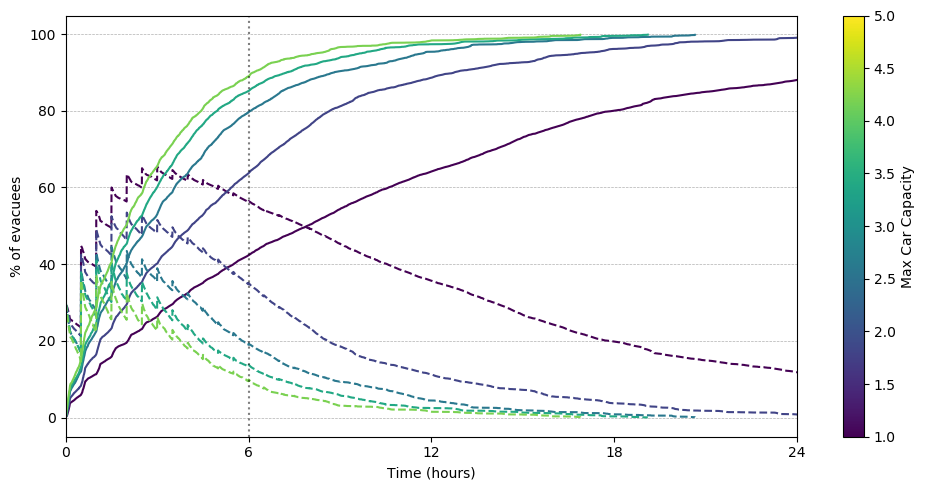

In [137]:
# NORMALISED JOURNEY TIMES TIME SERIES WITH MEAN AND STANDARD DEVIATION

fig, ax = plt.subplots(figsize=(10, 5))

n = len(list(evacdata['car_capacity'].unique()))
# Plot each run
for i, car_people in enumerate(evacdata['car_capacity'].unique()):
    run_data = evacdata[evacdata['car_capacity'] == car_people]
    color = plt.cm.viridis(i / n)  # Use the jet colormap
    plt.plot(run_data["time_minutes"]/60, run_data['evacuated_perc'], color=color)
    plt.plot(run_data["time_minutes"]/60, run_data['evacuating_perc'], linestyle='--', color=color)

# Update colorbar to use the jet colormap
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=evacdata['car_capacity'].min(), vmax=evacdata['car_capacity'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Max Car Capacity')

handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::2], labels[::2])
# ax.set_title('Evacuated people timeseries')
ax.set_ylabel('% of evacuees')
ax.set_xlabel('Time (hours)')
ax.set_xlim(0, 24)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.axvline(x=6, color='k', linestyle='dotted', alpha=0.5)
ax.set_xticks([0, 6, 12, 18, 24])

plt.tight_layout()
plt.savefig('figures_v02/evac_timeseries_carsharing.png')

In [119]:
fig, ax = plt.subplots(fiagsize=(10, 6))

for i, car_people in enumerate(journey_metrics['car_capacity'].unique()):
    run_data = journey_metrics[journey_metrics['car_capacity'] == car_people]
    sns.kdeplot(run_data['normalised_journey_time'], label=f'{car_people} people per car')

TypeError: __init__() got an unexpected keyword argument 'fiagsize'

/home/amcquaid139/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


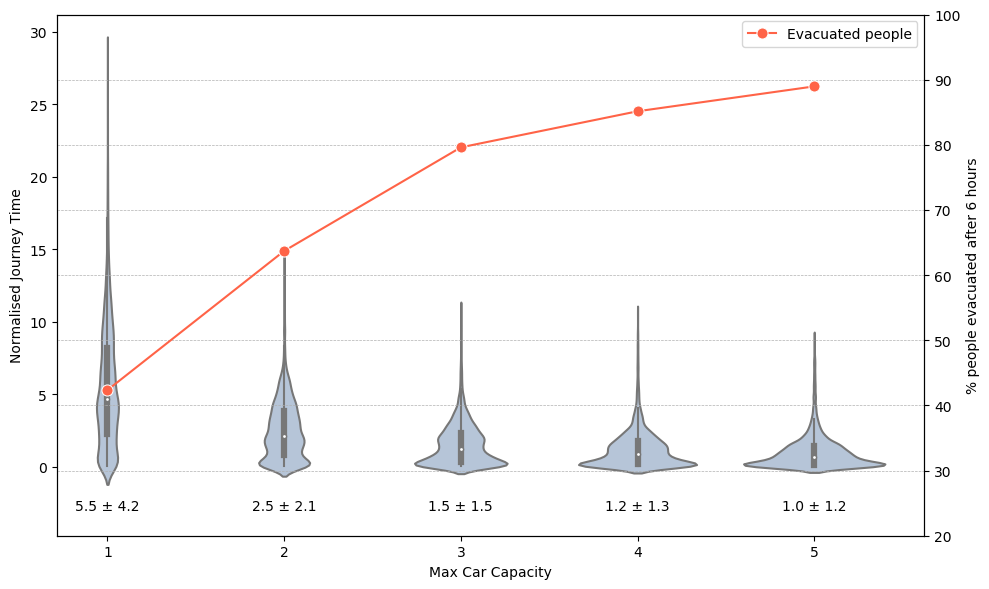

In [138]:
evacdata['car_capacity-1'] = evacdata['car_capacity'] - 1
evacdata['evacuated_perc'] = evacdata['get_no_evacuated'] / evacdata['population'] * 100
fig, ax = plt.subplots(figsize=(10, 6))

sns.violinplot(data=journey_metrics, x="car_capacity", y="normalised_journey_time", color='lightsteelblue', ax=ax, label='Normalised Journey Time')
ax.set_ylabel('Normalised Journey Time')

# Get the x positions of the violin plots
x_positions = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]
ax.set_xlabel('Max Car Capacity')

ax2 = ax.twinx()
sns.lineplot(data=evacdata[evacdata['time_minutes'] == 360], x='car_capacity-1', y='evacuated_perc', color='tomato', ax=ax2, markers=True, marker='o', markersize=8, label='Evacuated people')

ax2.set_ylabel('% people evacuated after 6 hours')

# Create a combined legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')
ax2.set_ylim(20, 100)

# Calculate mean and standard deviation for each violin
means = journey_metrics.groupby('car_capacity')['normalised_journey_time'].mean()
stds = journey_metrics.groupby('car_capacity')['normalised_journey_time'].std()

# Offset the start of the y axis to make room for annotations
ax.set_ylim(bottom=ax.get_ylim()[0] - 2)

# Annotate mean and standard deviation
for i, evp in enumerate(means.index):
    mean = means[evp]
    std = stds[evp]
    ax.text(i, -3, f'{mean:.1f} ± {std:.1f}', horizontalalignment='center', size='small', color='black', fontsize=10)

ax2.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('./figures_v02/njt_evac_violin_carsharing.png')

Text(0,0.5,'Evacuated people')

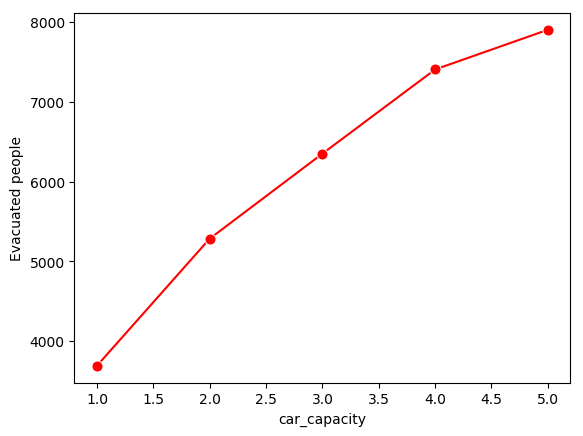

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=evacdata[evacdata['time_minutes']== 360], x='car_capacity', y='get_no_evacuated', color='red', ax=ax, markers=True, marker='o', markersize=8)
ax.set_ylabel('Evacuated people')

In [ ]:
evacdata[evacdata['time_minutes']== 360]

,run_number,terminate_evac_distance_km,population,max_walking_distance_km,warning_interval_time_mins,evacuation_probability,tick_time_in_mins,over_break_probability,[step],ticks,get_no_active_cars,get_no_walking,get_no_evacuating,get_no_evacuated,get_no_in_cars,no_people_per_car,car_capacity,time_minutes
1200,1,0.3,15000,1,30,0.3,0.3,0.06,1200,1200,11068,0,11068,3696,11068,1.000000,1,360.0
17279,1,0.3,15000,1,30,0.3,0.3,0.06,1200,1200,6063,0,9488,5285,9488,1.564902,2,360.0
27250,1,0.3,15000,1,30,0.3,0.3,0.06,1200,1200,4571,0,8425,6348,8425,1.843142,3,360.0
35329,1,0.3,15000,1,30,0.3,0.3,0.06,1200,1200,3717,0,7389,7401,7389,1.987893,4,360.0
42309,1,0.3,15000,1,30,0.3,0.3,0.06,1200,1200,3339,0,6866,7897,6866,2.056304,5,360.0


In [ ]:
journey_metrics[journey_metrics['car_capacity'] == 2].head()

,car_id,passengers,ideal_time,actual_time,start_tick,end_tick,car_capacity,start_time_minutes,normalised_journey_time,start_time_bin
13419,29054,2,0.766875,2.1,0,7,2,NaN,NaN,NaN
13420,10757,2,0.765000,3.3,0,11,2,NaN,NaN,NaN
13421,27382,2,0.765000,3.3,0,11,2,NaN,NaN,NaN
13422,30757,2,1.083125,3.3,0,11,2,NaN,NaN,NaN
13423,31168,2,1.153125,3.3,0,11,2,NaN,NaN,NaN


In [ ]:
journey_metrics['car_capacity'].unique()

array([1, 2, 3, 4, 5])

In [ ]:
journey_metrics['car_capacity'].value_counts()

1    13419
2     8382
3     6870
4     6151
5     5767
Name: car_capacity, dtype: int64